In [3]:
# Ta Cao Son - B22DCCVT445

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load dữ liệu
df = pd.read_csv('diabetes.csv')

print("Thông tin dataset:")
print(f"Kích thước: {df.shape}")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nThông tin dữ liệu:")
print(df.info())
print(f"\nThống kê mô tả:")
print(df.describe())
print(f"\nSố lượng giá trị thiếu:")
print(df.isnull().sum())
print(f"\nPhân bổ Outcome:")
print(df['Outcome'].value_counts())
print(f"\nTỷ lệ Outcome:")
print(df['Outcome'].value_counts(normalize=True))

Thông tin dataset:
Kích thước: (768, 9)

Các cột: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Thống kê mô tả:
       Pregnancies     

In [5]:
# Ta Cao Son - B22DCCVT445

# Tách features và target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Xử lý giá trị 0 (có thể là missing values) trong một số cột
# Thay thế 0 bằng median cho các cột quan trọng
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_fix:
    X[col] = X[col].replace(0, X[col].median())

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nPhân bổ y_train: {np.bincount(y_train)}")
print(f"Phân bổ y_test: {np.bincount(y_test)}")

Training set: (614, 8)
Test set: (154, 8)

Phân bổ y_train: [400 214]
Phân bổ y_test: [100  54]


In [6]:
# Ta Cao Son - B22DCCVT445
# Model 1: Dense với Dropout (7+ Layers)
def create_model_1(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [7]:
# Model 2: Dense với Batch Normalization (7+ Layers)
def create_model_2(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Model 3: Dense với Dropout + Batch Normalization (7+ Layers)
def create_model_3(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
# Hàm compile và train model
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=100):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Chia validation set từ training set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (491, 8)
Validation set: (123, 8)
Test set: (154, 8)


In [9]:
# Nguyễn Thị Trang - B22DCDT316 

# Training Model 1
print("=" * 50)
print("Training Model 1: Dense với Dropout")
print("=" * 50)
model_1 = create_model_1(X_train_final.shape[1])
history_1 = train_model(model_1, X_train_final, y_train_final, X_val, y_val, "Model 1", epochs=100)

Training Model 1: Dense với Dropout
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6517 - loss: 0.6837 - val_accuracy: 0.6504 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6517 - loss: 0.6688 - val_accuracy: 0.6504 - val_loss: 0.6387 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.6308 - val_accuracy: 0.6504 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.5713 - val_accuracy: 0.6504 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.5369 - val_accuracy: 0.6504 - val_loss: 0.4743 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.5045 - val_accuracy: 0.6504 - val_loss: 0.4683 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

In [10]:
# Training Model 2
print("=" * 50)
print("Training Model 2: Dense với Batch Normalization")
print("=" * 50)
model_2 = create_model_2(X_train_final.shape[1])
history_2 = train_model(model_2, X_train_final, y_train_final, X_val, y_val, "Model 2", epochs=100)


Training Model 2: Dense với Batch Normalization
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6497 - loss: 0.6254 - val_accuracy: 0.6341 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7332 - loss: 0.4951 - val_accuracy: 0.7154 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7719 - loss: 0.4490 - val_accuracy: 0.7398 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7963 - loss: 0.4159 - val_accuracy: 0.7317 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8350 - loss: 0.3851 - val_accuracy: 0.6911 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8432 - loss: 0.3647 - val_accuracy: 0.6911 - val_loss: 0.5907 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

In [11]:
# Training Model 3
print("=" * 50)
print("Training Model 3: Dense với Dropout + Batch Normalization")
print("=" * 50)
model_3 = create_model_3(X_train_final.shape[1])
history_3 = train_model(model_3, X_train_final, y_train_final, X_val, y_val, "Model 3", epochs=100)

Training Model 3: Dense với Dropout + Batch Normalization
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5866 - loss: 0.6697 - val_accuracy: 0.6504 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6375 - loss: 0.6635 - val_accuracy: 0.6504 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6415 - loss: 0.6436 - val_accuracy: 0.6504 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6456 - loss: 0.6180 - val_accuracy: 0.6504 - val_loss: 0.6340 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6253 - loss: 0.6225 - val_accuracy: 0.6504 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6558 - loss: 0.6052 - val_accuracy: 0.6504 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━

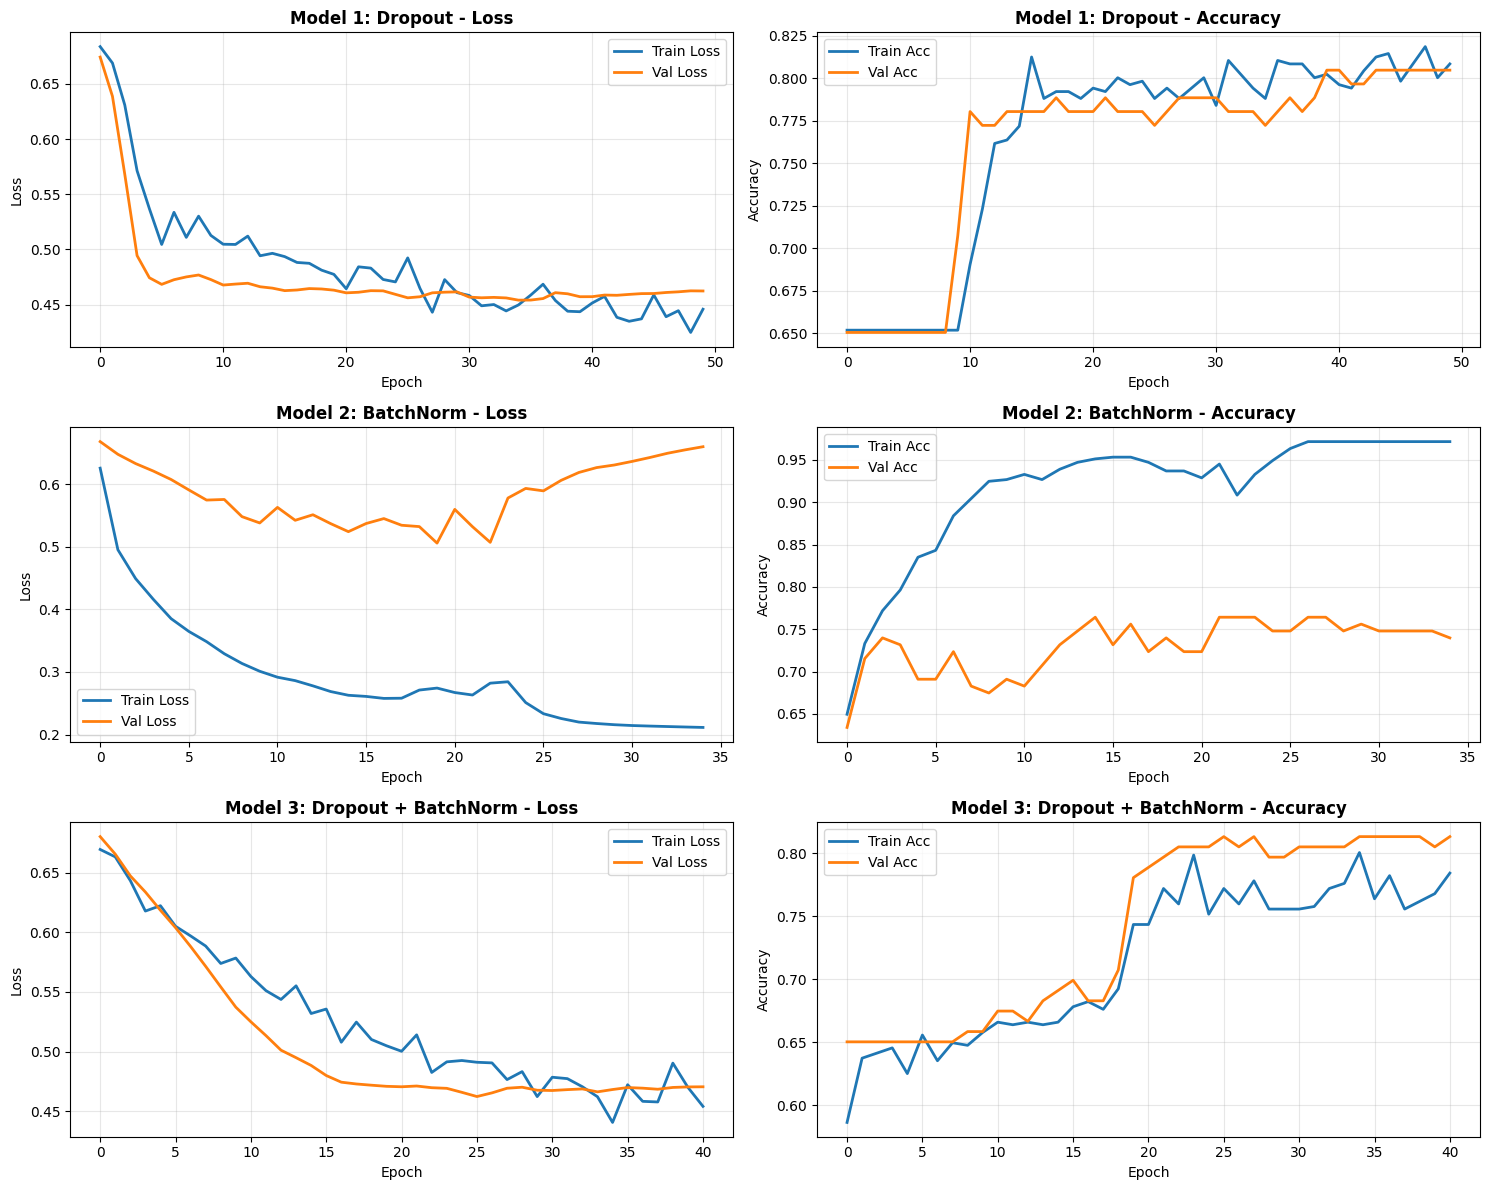

In [12]:
# Visualize training history để đánh giá overfitting
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

models_data = [
    
    (history_1, "Model 1: Dropout"),
    (history_2, "Model 2: BatchNorm"),
    (history_3, "Model 3: Dropout + BatchNorm")
]

for idx, (history, title) in enumerate(models_data):
    # Loss plot
    axes[idx, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[idx, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[idx, 0].set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[idx, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axes[idx, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    axes[idx, 1].set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Nguyễn Thị Trang - B22DCDT316 
# Hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test, history, model_name):
    # Dự đoán
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Tính các metrics
    mae = mean_absolute_error(y_test, y_pred_proba)
    mse = mean_squared_error(y_test, y_pred_proba)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(y_test, y_pred)

    # Đánh giá overfitting
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Loss gap (overfitting indicator)
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    loss_gap = final_val_loss - final_train_loss

    # Accuracy gap
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    acc_gap = final_train_acc - final_val_acc

    results = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Accuracy': accuracy,
        'Train Loss': final_train_loss,
        'Val Loss': final_val_loss,
        'Loss Gap': loss_gap,
        'Train Acc': final_train_acc,
        'Val Acc': final_val_acc,
        'Acc Gap': acc_gap,
        'History': history
    }

    return results, y_pred, y_pred_proba

In [14]:
# đánh giá tất cả các mô hình
results_1, y_pred_1, y_pred_proba_1 = evaluate_model(model_1, X_test_scaled, y_test, history_1, "Model 1")
results_2, y_pred_2, y_pred_proba_2 = evaluate_model(model_2, X_test_scaled, y_test, history_2, "Model 2")
results_3, y_pred_3, y_pred_proba_3 = evaluate_model(model_3, X_test_scaled, y_test, history_3, "Model 3")

# Tạo bảng so sánh
comparison_df = pd.DataFrame([results_1, results_2, results_3])
print("\n" + "=" * 80)
print("SO SÁNH CÁC MÔ HÌNH")
print("-" * 80)
print(comparison_df[['Model', 'MAE', 'MSE', 'RMSE', 'Accuracy', 'Loss Gap', 'Acc Gap']].to_string(index=False))


SO SÁNH CÁC MÔ HÌNH
--------------------------------------------------------------------------------
  Model      MAE      MSE     RMSE  Accuracy  Loss Gap   Acc Gap
Model 1 0.319901 0.166455 0.407988  0.759740  0.016512  0.003676
Model 2 0.316159 0.169541 0.411753  0.733766  0.448321  0.231649
Model 3 0.321945 0.165146 0.406382  0.766234  0.016442 -0.028894


In [15]:
# Nguyễn Thị Trang - B22DCDT316 

# BƯỚC KHẮC PHỤC LỖI: Gán Model 3 cho biến best_model
best_model = model_3

# Lưu mô hình và scaler
best_model.save('diabetes_model.h5')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n✅ Đã lưu mô hình tốt nhất (Model 3) vào: diabetes_model.h5")
print(f"✅ Đã lưu scaler vào: scaler.pkl")


✅ Đã lưu mô hình tốt nhất (Model 3) vào: diabetes_model.h5
✅ Đã lưu scaler vào: scaler.pkl
